In [1]:
# noise sources: stellar flux variations, orientiation angle noise, telescope polarization

# fitting params: (albedo*polarization fraction), {Omega, inclination} or {apparent inc, orbAxisAng angle}
# additional real params: Q+U+V offsets

# need to do a disk integration since there isn't a single path that light takes
#    - need to account for angles spanning the visible portion of the illuminated hemisphere

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import EPPE_Simulator as eppe
import astropy.constants as const
import time

# from EPPE_Simulator import cross_match
# cross_match.cross_match_tables()

In [3]:
expTime = 1
intTime = 10*3*24.

In [160]:
systems = eppe.Systems(load=True)
# mission = eppe.EPPE(rad=0.8) # POMM
mission = eppe.EPPE() # EPPE

# tic = time.time()
# stokesCurves = mission.observe_polarization(systems, expTime, intTime)
# toc = time.time()
# print('Took', int(np.rint(toc-tic)), 'seconds')

FOMs = mission.compute_FOM(systems, expTime, intTime)
# stokesCurves_ideal = mission.observe_polarization(systems, expTime, intTime, photonNoise=False, pStart=0)
# fps, fstars, times, phases = mission.observe_photometric(systems, expTime, intTime, photonNoise=True, pStart=0)

In [181]:
nPlanets = 5
fullNames = np.array([])
fullInds = np.array([], dtype=int)
for teqMin in range(0,3000,500):
    if teqMin<2500:
        teqMax = teqMin+500
    else:
        teqMax = np.inf
    inds = np.where(np.logical_and(teqMin <= teq, teq < teqMax))[0]
    order = np.argsort(-FOMs[inds])
    names = systems.catalogue['name'][inds][order][:nPlanets]
    fullNames = np.append(fullNames, names)
    fullInds = np.append(fullInds, inds[order][:nPlanets])
    print(teqMin, '< Teq <', teqMax)
    print('names = np.array([\''+'\', \''.join(names)+'\'])')
    print('Teqs = np.array(['+', '.join(np.rint(teq[inds][order][:nPlanets]).astype(int).astype(str))+'])')
    print('Rps = np.array(['+', '.join(np.round(systems.catalogue['rp'][inds][order][:nPlanets]/const.R_jup.value,1).astype(str))+'])\n')
    
nPlanets = 10
inds = np.where(systems.catalogue['rp']/const.R_earth.value < 4)[0]
order = np.argsort(-FOMs[inds])
names = systems.catalogue['name'][inds[order][:nPlanets]]
fullNames = np.append(fullNames, names)
fullInds = np.append(fullInds, inds[order][:nPlanets])
print('Rp < 4 Rearth')
print('names = np.array([\''+'\', \''.join(names)+'\'])')
print('Teqs = np.array(['+', '.join(np.rint(teq[inds][order][:nPlanets]).astype(int).astype(str))+'])')
print('Rps = np.array(['+', '.join(np.round(systems.catalogue['rp'][inds][order][:nPlanets]/const.R_jup.value,1).astype(str))+'])\n')

fullNames = np.unique(fullNames)
fullInds = np.unique(fullInds)

0 < Teq < 500
names = np.array(['GJ 581 b', 'GJ 876 c', 'HIP 57274 c', '55 Cnc c', 'HD 3651 b'])
Teqs = np.array([472, 230, 455, 494, 435])
Rps = np.array([0.4, 1.2, 1.3, 0.8, 0.9])

500 < Teq < 1000
names = np.array(['HD 103720 b', '55 Cnc b', 'WASP-69 b', 'GJ 86 b', 'WASP-10 b'])
Teqs = np.array([926, 716, 988, 661, 970])
Rps = np.array([1.3, 1.2, 1.1, 1.2, 1.1])

1000 < Teq < 1500
names = np.array(['51 Peg b', 'HD 189733 b', 'HD 75289 b', 'HD 209458 b', 'HD 187123 b'])
Teqs = np.array([1333, 1192, 1463, 1477, 1467])
Rps = np.array([1.3, 1.1, 1.3, 1.4, 1.3])

1500 < Teq < 2000
names = np.array(['tau Boo b', 'HD 212301 b', 'WASP-77 A b', 'ups And b', 'HD 179949 b'])
Teqs = np.array([1685, 1871, 1743, 1530, 1580])
Rps = np.array([1.1, 1.3, 1.4, 1.2, 1.2])

2000 < Teq < 2500
names = np.array(['WASP-18 b', 'HD 143105 b', 'WASP-76 b', 'WASP-121 b', 'KELT-7 b'])
Teqs = np.array([2478, 2030, 2182, 2359, 2090])
Rps = np.array([1.2, 1.2, 1.8, 1.9, 1.6])

2500 < Teq < inf
names = np.array(['WA

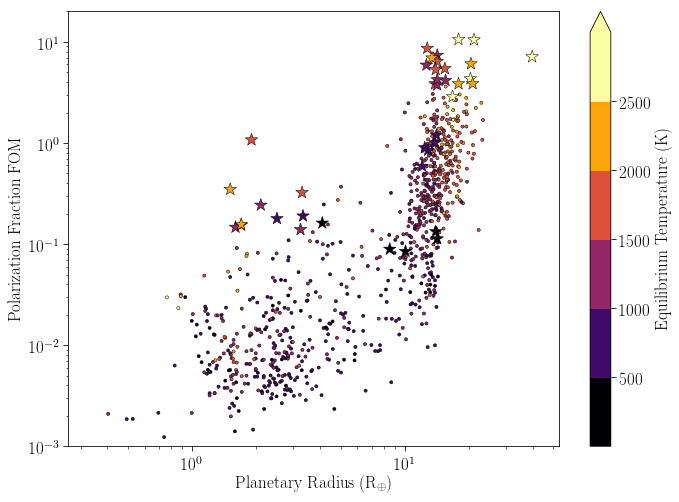

In [193]:
teq = 0.25**0.25*systems.catalogue['teff']*np.sqrt(systems.catalogue['rstar']/systems.catalogue['a'])

fig = plt.figure(figsize=(11,8))
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3,2e1)
ax.set_ylabel(r'$\rm Polarization~Fraction~FOM$')
ax.set_xlabel(r'$\rm Planetary~Radius~(R_{\oplus})$')

cmap = plt.get_cmap('inferno', 6)

scat = ax.scatter(x=systems.catalogue['rp']/const.R_earth.value, y=FOMs, c=teq, marker='o', s=10, cmap=cmap, vmin=0, vmax=3000, edgecolor='k', linewidth=0.5)
scat = ax.scatter(x=systems.catalogue['rp'][fullInds]/const.R_earth.value, y=FOMs[fullInds], c=teq[fullInds], marker='*', s=175, cmap=cmap, vmin=0, vmax=3000, edgecolor='k', linewidth=0.5)
cbar = fig.colorbar(scat, ax=ax, label=r'$\rm Equilibrium~Temperature~(K)$', extend='max')
cbar.set_ticks([500,1000,1500,2000,2500])

plt.show()
plt.close(fig)

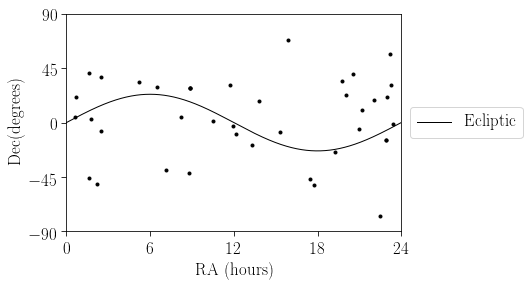

In [267]:
plt.plot(systems.catalogue['ra'][fullInds]*24./360., systems.catalogue['dec'][fullInds], '.', c='k')
x = np.linspace(0,24,1000)
y = 23.43681*np.sin(x*np.pi/12.)
plt.plot(x, y, c='k', lw=1, label=r'$\rm Ecliptic$')
plt.xlabel(r'$\rm RA~(hours)$')
plt.ylabel(r'$\rm Dec (degrees)$')
plt.xticks(np.linspace(0,24,5))
plt.yticks(np.linspace(-90,90,5))
plt.xlim(0,24)
plt.ylim(-90,90)
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.show()

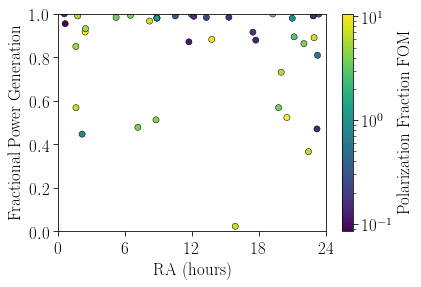

Mean Power Generation: 83% full capacity
Median Power Generation: 92% full capacity


In [278]:
x = systems.catalogue['ra'][fullInds]*24./360.
yEcliptic = 23.43681*np.sin(x*np.pi/12.)
y = np.cos((systems.catalogue['dec'][fullInds] - yEcliptic)*np.pi/180.)

fig = plt.gcf()
ax = plt.gca()

scat = ax.scatter(x=x, y=y, c=FOMs[fullInds], marker='.', s=150, cmap='viridis', norm=colors.LogNorm(), edgecolors='k', linewidth=0.5)
cbar = fig.colorbar(scat, ax=ax, label=r'$\rm Polarization~Fraction~FOM$')
ax.set_xlabel(r'$\rm RA~(hours)$')
ax.set_ylabel(r'$\rm Fractional~Power~Generation$')
ax.set_xticks(np.linspace(0,24,5))
ax.set_xlim(0,24)
ax.set_ylim(0,1)
plt.show()

print('Mean Power Generation: '+str(int(np.rint(np.mean(y)*100)))+'% full capacity')
print('Median Power Generation: '+str(int(np.rint(np.median(y)*100)))+'% full capacity')

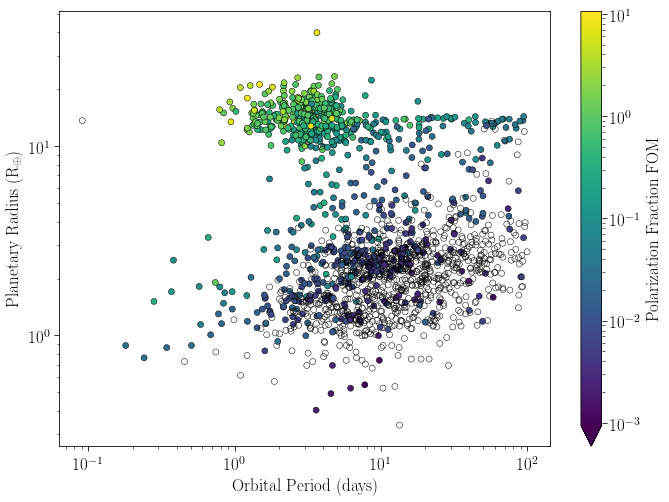

In [255]:
fig = plt.figure(figsize=(11,8))
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\rm Orbital~Period~(days)$')
ax.set_ylabel(r'$\rm Planetary~Radius~(R_{\oplus})$')

cmap = plt.get_cmap('viridis')

scat = ax.scatter(y=systems.catalogue['rp']/const.R_earth.value, x=systems.catalogue['per'], c=FOMs, marker='o', cmap=cmap, norm=colors.LogNorm(), edgecolor='k', linewidth=0.5)
cbar = fig.colorbar(scat, ax=ax, label=r'$\rm Polarization~Fraction~FOM$', extend='min')
# cbar.set_ticks([500,1000,1500,2000,2500])

plt.show()
plt.close(fig)

In [65]:
systems.catalogue['name'][np.argsort(systems.catalogue['per'])][:1]

array(['PSR J1719-1438 b'], dtype=object)

In [286]:
eppe.rayleigh_scatter(90, np.array([1,0,0,0]).reshape(4,1))

array([[ 0.75],
       [-0.75],
       [ 0.  ],
       [ 0.  ]])

In [349]:
Ifull = []
theta = np.linspace(0,360,100)
for i in theta:
    Ifull.append(eppe.rayleigh_scatter(i, np.array([1,0,0,0]).reshape(4,1)))
Ifull = np.array(Ifull)

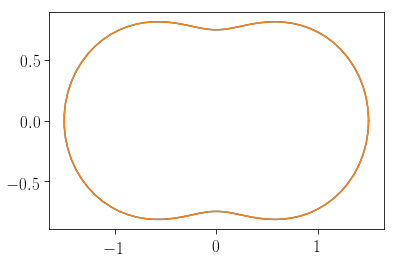

In [350]:
I = Ifull[:,0,0]
x = I*np.cos(theta*np.pi/180)
y = I*np.sin(theta*np.pi/180)
plt.plot(x, y)

I = 0.75*(1+np.cos(theta*np.pi/180)**2)
x = I*np.cos(theta*np.pi/180)
y = I*np.sin(theta*np.pi/180)
plt.plot(x, y)

plt.show()

In [545]:
# r = 300e-9
# r = 120*1e-12 #H2
r = 152*1e-12 #O2
V = 4./3.*np.pi*r**3
# wavs = np.linspace(380e-9, 740e-9, 100)
wavs = np.array([589.3e-9])
# n = 1.000132 # hydrogen gas
n = 1.0003 # air
# Ps = np.linspace(0,1,10000)*const.atm.value
# dP = Ps[1]-Ps[0]
Ps = 1*const.atm.value
dP = 1
Np = np.sum(Ps/(const.k_B.value*273.15)*dP)
# sig = 9*np.pi**2*V**2/(2*wavs**4)*((n**2-1)/(n**2+2))**2*1e11
# sig = 24*Np*np.pi**3*V**2/wavs**4*((n**2-1)/(n**2+2))**2
# sig = 32*np.pi**3/(3*Np*wavs**4)*(n-1)**2
No = 2.69e19
sig = 32*np.pi**3/(3*No**2*wavs**4)*(n-1)**2

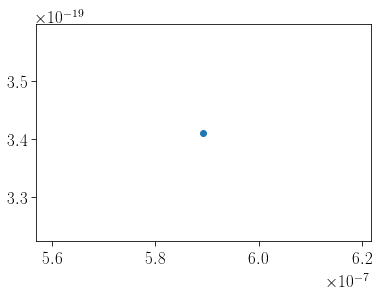

In [546]:
plt.plot(wavs, sig, 'o')
plt.show()

In [9]:
# i = 1
i = np.where(systems.catalogue['name']=='WASP-12 b')[0][0]
# i = np.where(systems.catalogue['name']=='HD 189733 b')[0][0]
# i = np.where(systems.catalogue['name']=='HD 209458 b')[0][0]
# i = np.where(systems.catalogue['name']=='KELT-7 b')[0][0]
# i = np.where(systems.catalogue['name']=='KELT-9 b')[0][0]

In [10]:
print('Name:', systems.catalogue['name'][i])
print('Period:', np.round(systems.catalogue['per'][i], 2), 'days')
print('Transit Depth: '+str(np.round((systems.catalogue['rp'][i]/systems.catalogue['rstar'][i])**2*100, 3))+'%')
print('Equilibrium Temperature: '+str(int(np.rint((systems.catalogue['teff'][i]*np.sqrt(systems.catalogue['rstar'][i]/systems.catalogue['a'][i])))))+' K')
print('Distance: '+str(int(np.rint(systems.catalogue['dist'][i]/const.pc.value)))+' pc')
print('Radius: '+str(np.round(systems.catalogue['rp'][i]/const.R_jup.value, 2))+' Rjup')

Name: WASP-12 b
Period: 1.09 days
Transit Depth: 1.384%
Equilibrium Temperature: 3541 K
Distance: 432 pc
Radius: 1.82 Rjup


NameError: name 'stokesCurves' is not defined

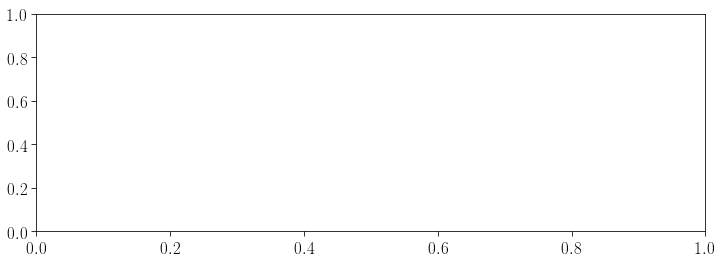

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(stokesCurves[i][-1], (stokesCurves[i][0]/np.median(fstars[i])-1)*1e6, '.', c='k')
ax.plot([0,1], [0,0], lw=1, c='k')
ax.set_ylabel(r'$\rm F_p/F_*~({\rm ppm})$')
ax.set_xlabel(r'$\rm Orbital~Phase$')
ax.set_xlim(0,1)
plt.show()
plt.close(fig)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(stokesCurves[i][-1], np.sqrt(stokesCurves[i][1]**2+stokesCurves[i][2]**2)/stokesCurves[i][0]*1e6,
        '.', c='k')
ax.set_ylabel(r'$\rm Polarization~Fraction~(ppm)$')
ax.set_xlabel(r'$\rm Orbital~Phase$')
ax.set_xlim(0,1)
ax.set_ylim(0)
plt.show()
plt.close(fig)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(stokesCurves[i][-1], stokesCurves[i][1], '.', c='teal', label='Q')
ax.plot(stokesCurves[i][-1], stokesCurves[i][2], '.', c='darkorange', label='U')
# ax.plot(stokesCurves[i][-1], stokesCurves[i][3], '.', c='green', label='V')
ax.plot([0,1], [0,0], lw=1, c='k')
ax.set_ylabel(r'$\rm Polarized~Flux~(photons)$')
ax.set_xlabel(r'$\rm Orbital~Phase$')
ax.set_xlim(0,1)
ax.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.show()
plt.close(fig)